In [3]:
from sklearn.decomposition import PCA
from model.TransE import *
from model.ConvKB import ConvKB
from model.utils import *
from model.CustomTripletMarginLoss import CustomTripletMarginLoss
from argparse import Namespace
import torch
import torch.nn as nn
import sys
from torch.autograd import Variable
import torch.optim as optim
from numpy import linalg as LA
import numpy as np
from math import log10,floor
import json
import pickle
from sklearn.cluster import KMeans,MeanShift,SpectralClustering
from sklearn import mixture
from collections import Counter
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
# from ggplot import *
from model.CapsuleNet import *

In [4]:
START_CLUSTER = 1
END_CLUSTER = 425
WEIGHT_PATH = "/storage/quandh/OsGenePrio_convkb/data/convkb_param1/param4/ConvKB.pkl"
DEVICE = 2

In [4]:
#Load data to show attributes of gene
with open("./support/uniprot.pkl","rb") as f:
    uniprot = pickle.load(f)
    f.close()
with open("./support/pyrice.pkl","rb") as f:
    pyrice = pickle.load(f)
    f.close()
with open("./support/id_dict_2018", "rb") as f:
    id_dict_2018 = pickle.load(f)
    f.close()
with open("./support/loc_dict_2018", "rb") as f:
    loc_dict_2018 = pickle.load(f)
    f.close()
entity_total = get_total("./data/GENE/entity2id.txt")
relation_total = get_total("./data/GENE/relation2id.txt")
processed_entity_2_id = load_data("./data/GENE/entity2id.txt", ignore_first=True)
relation_2_id = load_data("./data/GENE/relation2id.txt", ignore_first=True)
triple_list = []
processed_id_2_entity = dict()
i = 0
with open("./data/GENE/entity2id.txt", 'r') as f:
    for line in f:
        if True and i == 0:
            i += 1
            continue
        line = line.strip()
        if line == '':
            continue
        parts = line.split("\t")
        processed_id_2_entity[int(parts[1])] = parts[0]
i = 0
triple_list =[]
with open("./data/GENE/triplet2id.txt", 'r') as f:
    for line in f:
        if True and i == 0:
            i += 1
            continue
        line = line.strip()
        if line == '':
            continue
        parts = line.split("\t")
        head = int(parts[0])
        tail = int(parts[1])
        rel = int(parts[2])
        triple_list.append((head,tail,rel))
net = ConvKB(entity_total,relation_total,150,150)
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(DEVICE) if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(WEIGHT_PATH, map_location=device)
    net.to(device)
else:
    checkpoint = torch.load(WEIGHT_PATH, map_location=lambda storage, loc: storage)
net.load_state_dict(checkpoint)
net.eval()
embedding_items = list(checkpoint.items())
data_train = embedding_items[0][1].cpu().numpy()

In [6]:
#RUN WITH ALL GENE
get_index_gene = []
for gene_name in id_dict_2018.keys():
    if gene_name in processed_entity_2_id.keys():
        get_index_gene.append(processed_entity_2_id[gene_name])          

In [ ]:
#RUN KMEANS
X = data_train[get_index_gene]
loss_kmeans = [] 
loss = 10000
for cluster in range(START_CLUSTER, END_CLUSTER):
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(X)
    loss_kmean = kmeans.inertia_
    print("Loss {} : {}".format(cluster,loss_kmean))
    loss_kmeans.append(loss_kmean)
    if loss_kmean < loss:
        loss = loss_kmean
        Y = kmeans.labels_

Loss 1 : 1074.246826171875
Loss 2 : 916.9052338434924
Loss 3 : 865.1535275420426
Loss 4 : 820.532900315034
Loss 5 : 786.162907934881
Loss 6 : 761.7964109459199
Loss 7 : 741.7435636012348
Loss 8 : 724.2830931870736
Loss 9 : 710.3668027609281
Loss 10 : 698.6184726099763
Loss 11 : 686.3633573449854
Loss 12 : 677.9626773318042
Loss 13 : 667.5463291323632
Loss 14 : 657.093838791505
Loss 15 : 647.5908613891951
Loss 16 : 638.4277746810775
Loss 17 : 632.0652312346275
Loss 18 : 626.2401919348387
Loss 19 : 619.0653082012641
Loss 20 : 613.5305725026981
Loss 21 : 611.5396327249134
Loss 22 : 607.4298934870324
Loss 23 : 599.9864189325201
Loss 24 : 594.5506147934966
Loss 25 : 590.3227884668397
Loss 26 : 584.2500499400481
Loss 27 : 581.4370259044352
Loss 28 : 578.3192797258409
Loss 29 : 574.3492859115146
Loss 30 : 571.2559974762017
Loss 31 : 567.2550560573201
Loss 32 : 564.2794492075136
Loss 33 : 561.373626690021
Loss 34 : 559.5419300240965
Loss 35 : 555.0444161328097
Loss 36 : 548.7342335689087
Loss 

In [14]:
loss_kmeans

[1074.2468,
 916.9052338434924,
 865.1535275420426,
 820.532900315034,
 786.162907934881,
 761.7964109459199,
 741.7435636012348,
 724.2830931870736,
 710.3668027609281,
 698.6184726099763,
 686.3633573449854,
 677.9626773318042,
 667.5463291323632,
 657.093838791505,
 647.5908613891951,
 638.4277746810775,
 632.0652312346275,
 626.2401919348387,
 619.0653082012641,
 613.5305725026981,
 611.5396327249134,
 607.4298934870324,
 599.9864189325201,
 594.5506147934966,
 590.3227884668397,
 584.2500499400481,
 581.4370259044352,
 578.3192797258409,
 574.3492859115146,
 571.2559974762017,
 567.2550560573201,
 564.2794492075136,
 561.373626690021,
 559.5419300240965,
 555.0444161328097,
 548.7342335689087,
 546.7886836705878,
 542.6203894096652,
 539.5065320593812,
 537.7371682401089,
 534.5608697321511,
 532.3026205655791,
 529.8765168248551,
 527.2943582431366,
 525.2872914933586,
 523.1062334769579,
 520.8895839326058,
 518.7104163406257,
 516.8603090723351,
 515.2905614564513,
 511.6466884

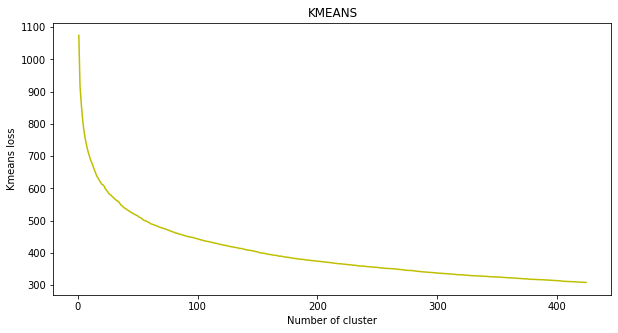

In [13]:
#VISUALIZE LOSS WITH CLUSTER KMEANS
plt.figure(figsize=[10, 5])
plt.plot(range(1,len(loss_kmeans)+1),loss_kmeans,'y-')
plt.title('KMEANS')
plt.xlabel('Number of cluster')
plt.ylabel('Kmeans loss')
plt.show()

In [8]:
# gmm = mixture.GaussianMixture(
#         n_components=12, covariance_type='full').fit(X)
# Y = gmm.predict(X)
# meanshift = MeanShift(bandwidth=2,bin_seeding=True).fit(X[0:500,:])
# Y = meanshift.labels_
# spex = SpectralClustering(n_clusters=3).fit(X[0:500,:])
# Y = meanshift.labels_
# Y

In [11]:
#PREPARE DATA FOR VISUALIZER
feat_cols = ['number'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = Y
df['label'] = df['label'].apply(lambda i: str(i))

print ('Size of the dataframe: {}'.format(df.shape))
rndperm = np.random.permutation(df.shape[0])

#COUNT NUMBER GENE IN EACH CLUSTER
counter = Counter(Y)
counter = dict(counter)
print(counter)

#VISUALIZER NUMBER GENE
NUMBER_GENE = 100 #NUMBER GENE IN CLUSTER
new_dict = dict()
list_index = []
for i in range(len(counter)):
    new_dict.setdefault(i,0)
for i in rndperm[:len(Y)]:
    if new_dict[Y[i]] > NUMBER_GENE:
        continue
    else:
        new_dict[Y[i]]+=1
        list_index.append(i)

Size of the dataframe: (25742, 101)
{78: 213, 37: 373, 70: 156, 1: 3521, 68: 256, 52: 120, 88: 190, 20: 117, 83: 264, 22: 286, 18: 193, 26: 240, 38: 158, 5: 420, 49: 241, 82: 258, 0: 521, 64: 277, 85: 581, 77: 110, 48: 520, 66: 141, 50: 265, 67: 166, 74: 258, 61: 174, 90: 186, 47: 221, 11: 268, 89: 220, 31: 253, 24: 252, 72: 344, 59: 277, 79: 158, 97: 181, 87: 245, 32: 596, 80: 330, 17: 93, 25: 678, 6: 195, 36: 429, 19: 166, 94: 288, 23: 147, 96: 202, 27: 129, 63: 150, 21: 149, 95: 209, 8: 131, 55: 251, 43: 171, 75: 151, 40: 276, 51: 269, 58: 180, 15: 131, 3: 195, 44: 197, 7: 242, 10: 160, 14: 284, 57: 167, 12: 381, 76: 244, 30: 114, 2: 179, 81: 144, 46: 130, 54: 146, 34: 177, 65: 317, 71: 222, 62: 127, 73: 182, 42: 302, 35: 160, 29: 204, 28: 273, 60: 303, 39: 204, 99: 127, 98: 234, 84: 322, 9: 158, 53: 171, 16: 193, 56: 125, 45: 145, 91: 257, 13: 242, 41: 172, 86: 183, 33: 82, 92: 73, 93: 103, 4: 114, 69: 42}


Explained variation per principal component: [0.16327016 0.08466046 0.05892706]


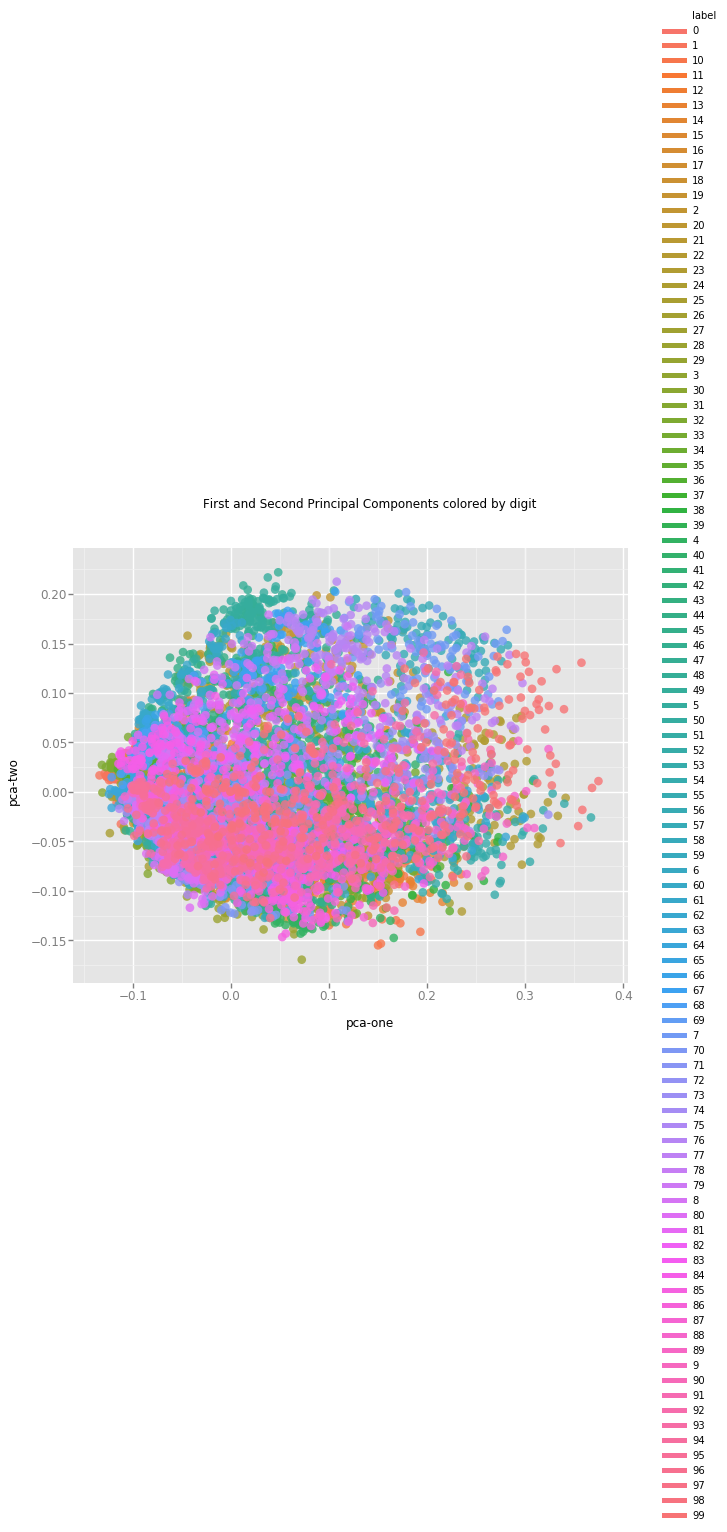

<ggplot: (-9223372029838166584)>

In [12]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
chart = ggplot(df.loc[list_index,:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")

chart

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9986 samples in 0.042s...
[t-SNE] Computed neighbors for 9986 samples in 31.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9986
[t-SNE] Computed conditional probabilities for sample 2000 / 9986
[t-SNE] Computed conditional probabilities for sample 3000 / 9986
[t-SNE] Computed conditional probabilities for sample 4000 / 9986
[t-SNE] Computed conditional probabilities for sample 5000 / 9986
[t-SNE] Computed conditional probabilities for sample 6000 / 9986
[t-SNE] Computed conditional probabilities for sample 7000 / 9986
[t-SNE] Computed conditional probabilities for sample 8000 / 9986
[t-SNE] Computed conditional probabilities for sample 9000 / 9986
[t-SNE] Computed conditional probabilities for sample 9986 / 9986
[t-SNE] Mean sigma: 0.060310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.421165
[t-SNE] KL divergence after 300 iterations: 2.242969
t-SNE done! Time elapsed: 215.0815560

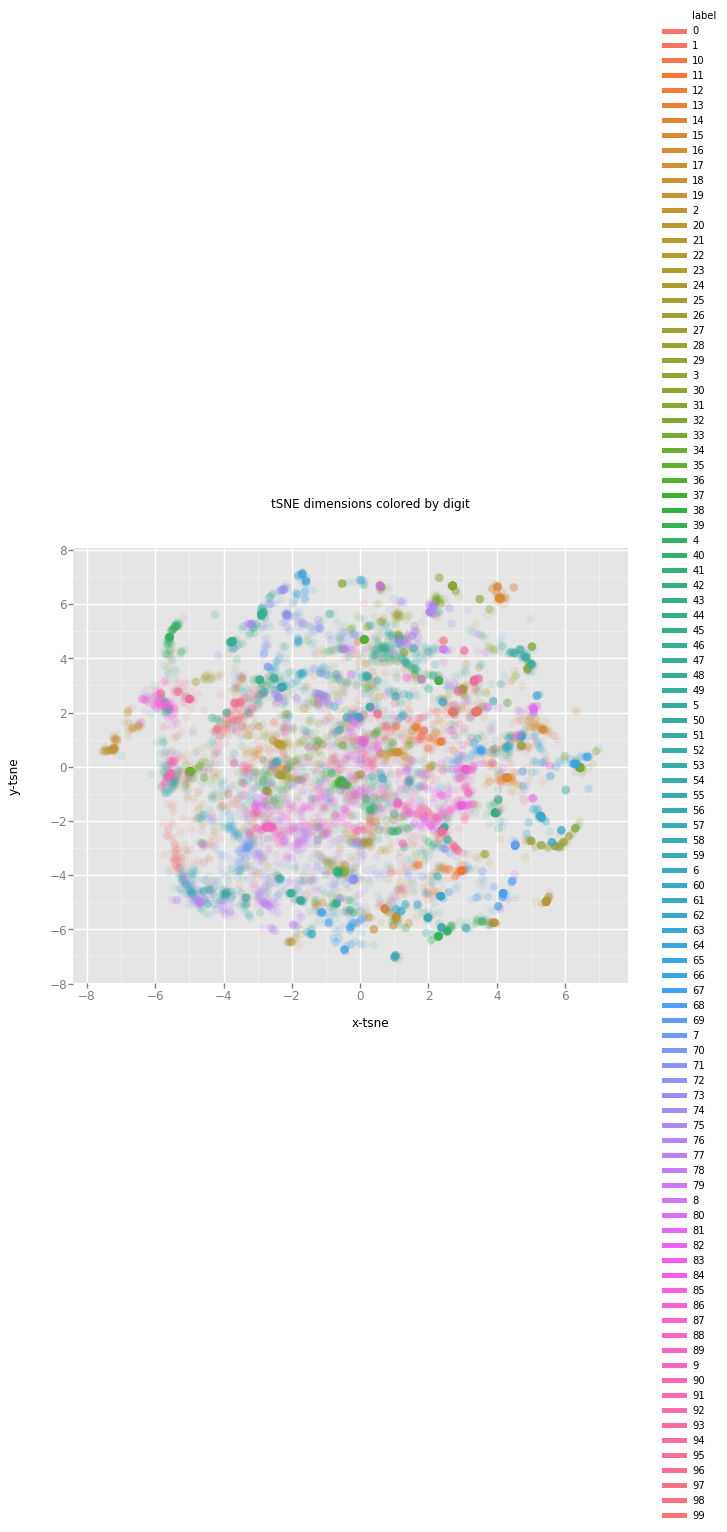

<ggplot: (-9223372029836323682)>

In [13]:
#VISUALIZER GENE IN KMEANS WITH TSNE
n_sne = 10000

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
tsne_results = tsne.fit_transform(df.loc[list_index,feat_cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
#df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne = df.loc[list_index,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

Cumulative explained variation for 50 principal components: 0.9231275916099548
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9986 samples in 0.016s...
[t-SNE] Computed neighbors for 9986 samples in 12.804s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9986
[t-SNE] Computed conditional probabilities for sample 2000 / 9986
[t-SNE] Computed conditional probabilities for sample 3000 / 9986
[t-SNE] Computed conditional probabilities for sample 4000 / 9986
[t-SNE] Computed conditional probabilities for sample 5000 / 9986
[t-SNE] Computed conditional probabilities for sample 6000 / 9986
[t-SNE] Computed conditional probabilities for sample 7000 / 9986
[t-SNE] Computed conditional probabilities for sample 8000 / 9986
[t-SNE] Computed conditional probabilities for sample 9000 / 9986
[t-SNE] Computed conditional probabilities for sample 9986 / 9986
[t-SNE] Mean sigma: 0.052478
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.131874
[t-SNE] KL 

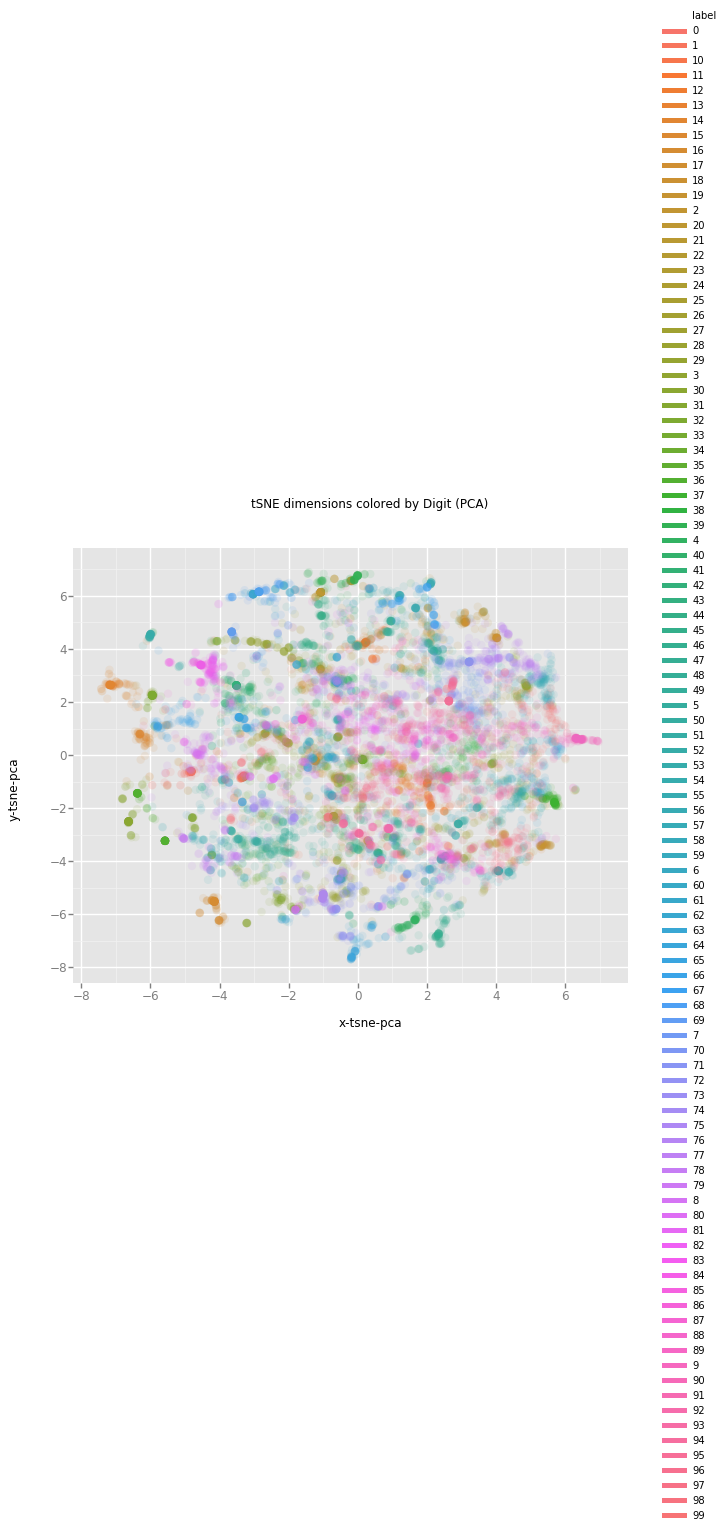

<ggplot: (7018928297)>

In [14]:
#VISUALIZER GENE IN KMEANS PCA + TSNE
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
n_sne = 6000
time_start = time.time()

#x = rndperm[:n_sne]
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
#tsne_pca_results = tsne.fit_transform(pca_result_50[x])
tsne_pca_results = tsne.fit_transform(pca_result_50[list_index])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = None
#df_tsne = df.loc[x,:].copy()
df_tsne = df.loc[list_index,:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart